# Introduction

The goal of this analysis is to build and explore different sentiment analysis models. I will use the following models:

- Naive Bayes Classifier
- LTSM
- CNN
- CNN-LTSM with Word2Vec



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Import the SMS data as a pandas DataFrame
df = pd.read_csv('clean_nus_sms.csv', index_col=0)
df.head()

,id,Message,length,country,Date
0,10120,Bugis oso near wat...,21,SG,2003/4
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,10124,Meet after lunch la...,22,SG,2003/4


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48598 entries, 0 to 55834
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       48598 non-null  int64 
 1   Message  48595 non-null  object
 2   length   48598 non-null  object
 3   country  48598 non-null  object
 4   Date     48598 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


Lets drop the null message rows

In [4]:
df.dropna(subset='Message',inplace=True)

# Pre-processing


### Lowercase string

In [5]:
#first lets make all messages lowercase

df['clean_message']=df.Message.apply(lambda x: x.lower())
df.head()

,id,Message,length,country,Date,clean_message
0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ..."
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......
4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...


### Remove punctuation

In [6]:
#Now lets remove all punctuation.

### Remove stopwords

Although removing stopwords is usually helpful for understanding the entities in text, for sentiment analysis it could make it more difficult to understand the meaning.

In [7]:
from nltk.corpus import stopwords

# View stopwords in english
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

I will not remove stopwords here

### Remove URLs

These are not needed in my opinion

In [8]:
#Using regular expressions to remove any URLs
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [9]:
df.clean_message = df.clean_message.apply(lambda text: remove_urls(text))

df.head()

,id,Message,length,country,Date,clean_message
0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ..."
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......
4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...


### Remove HTML tags

Again, these are not needed and I will remove them... if there are any

In [10]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [11]:
df.clean_message = df.clean_message.apply(lambda text: remove_html(text))

df.head()

,id,Message,length,country,Date,clean_message
0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ..."
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......
4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...


### Tokenize the messages

In [12]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
# Tokenize cleaned messages
df['message_tokenized'] = df.apply(lambda x: nltk.word_tokenize(x['clean_message']), axis=1)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eobri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,Message,length,country,Date,clean_message,message_tokenized
0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...,"[bugis, oso, near, wat, ...]"
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail..."
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...,"[i, dunno, until, when, ..., lets, go, learn, ..."
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......,"[den, only, weekdays, got, special, price, ......"
4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...,"[meet, after, lunch, la, ...]"


### Lemmatize

This reduces all words to their base form

In [13]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eobri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\eobri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
def lemmatize(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

In [15]:
df['message_lemmatize']=df.message_tokenized.apply(lambda x: lemmatize(x))
df.head()

,id,Message,length,country,Date,clean_message,message_tokenized,message_lemmatize
0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...,"[bugis, oso, near, wat, ...]","[bugis, oso, near, wat, ...]"
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, ,, crazy, .., avail..."
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...,"[i, dunno, until, when, ..., lets, go, learn, ...","[i, dunno, until, when, ..., let, go, learn, p..."
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den only weekdays got special price... haiz......,"[den, only, weekdays, got, special, price, ......","[den, only, weekday, got, special, price, ...,..."
4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...,"[meet, after, lunch, la, ...]","[meet, after, lunch, la, ...]"


# Exploratory Analysis

In [16]:
#We see there are issues with how some of the countries are named. Theres USA and United States for example
df.country.unique()

array(['SG', 'MY', 'India', 'Pakistan', 'United States', 'Canada',
       'unknown', 'Serbia', 'United Kingdom', 'France', 'Singapore',
       'China', 'Malaysia', 'Sri Lanka', 'Spain', 'Bangladesh',
       'Philippines', 'Macedonia', 'Romania', 'Kenya', 'Slovenia',
       'New Zealand', 'Nigeria', 'Ghana', 'Indonesia', 'Nepal', 'Morocco',
       'USA', 'Lebanon', 'india', 'Trinidad and Tobago', 'INDIA',
       'srilanka', 'jamaica', 'Hungary', 'Australia', 'Italia',
       'BARBADOS', 'Turkey', 'UK'], dtype=object)

In [17]:
# Correct values
df = df.replace({'country':{'SG':'Singapore', 
                            'USA':'United States',
                            'india':'India',
                            'INDIA':'India',
                            'srilanka':'Sri Lanka',
                            'UK':'United Kingdom',
                            'BARBADOS':'Barbados',
                            'jamaica':'Jamaica',
                            'MY':'Malaysia',
                            'unknown':'Unknown'}})


In [18]:
df['country'].value_counts(normalize=True).round(4)*100

#We see most of the texts are from SingaPore. Interesting

Singapore              65.47
India                  14.58
United States          11.69
Sri Lanka               2.15
Malaysia                1.58
Pakistan                1.55
Unknown                 1.24
Canada                  0.41
Bangladesh              0.26
China                   0.22
Philippines             0.14
Indonesia               0.10
United Kingdom          0.08
Nepal                   0.08
Hungary                 0.06
Serbia                  0.05
Kenya                   0.04
Ghana                   0.04
Italia                  0.02
Trinidad and Tobago     0.02
Lebanon                 0.02
Turkey                  0.02
Nigeria                 0.02
New Zealand             0.02
Slovenia                0.02
Macedonia               0.02
Morocco                 0.02
Australia               0.02
Romania                 0.02
Jamaica                 0.02
Barbados                0.02
Spain                   0.01
France                  0.01
Name: country, dtype: float64

In [19]:
df.Date.nunique()
#Small sample of texts

27

In [20]:
df['Date'].value_counts(normalize=True).round(4)*100

#Interesting, we have data all over the place

2011/3     21.47
2003/4     20.18
2011/4     11.84
2011/12    11.52
2011/11     8.31
2011/1      7.50
2011/2      7.48
2014/9      4.78
2010/11     1.89
2010/12     1.16
2011/8      0.55
2015/2      0.54
2014/11     0.48
2012/3      0.34
2012/5      0.31
2012/7      0.30
2011/5      0.23
2011/9      0.22
2012/2      0.19
2011/6      0.15
2015/3      0.12
2013/5      0.11
2012/8      0.11
2014/12     0.10
2012/6      0.07
2012/4      0.04
2012/10     0.02
Name: Date, dtype: float64

# Naive Bayes Classifier

Although not great, I will be using NLTKs twitter data that has already been classified to train all models

In [21]:
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import twitter_samples

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\eobri\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eobri\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eobri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# Getting all positive tweets
positive_tweets = twitter_samples.strings('positive_tweets.json')
# Getting all negative tweets
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [23]:
print(positive_tweets[100])

print('There are {} positive tweets.'.format(len(positive_tweets)))

@metalgear_jp @Kojima_Hideo I want you're T-shirts ! They are so cool ! :D
There are 5000 positive tweets.


In [24]:
print(negative_tweets[100])

print('There are {} negative tweets.'.format(len(negative_tweets)))

@amedefu Me  too。。。_:(´ω`」 ∠):_
There are 5000 negative tweets.


In [25]:
# Create tokens from the positive tweets
pos_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')

print(pos_tweet_tokens[100])

# Create tokens from the positive tweets
neg_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

print(neg_tweet_tokens[100])

['@metalgear_jp', '@Kojima_Hideo', 'I', 'want', "you're", 'T-shirts', '!', 'They', 'are', 'so', 'cool', '!', ':D']
['@amedefu', 'Me', 'too', '。', '。', '。', '_', ':(', '´', 'ω', '`', '」', '∠', '):', '_']


In [26]:
#For the SMS data I removed URLs and HTML tags so I need to do the same. 

positive_cleaned_tweets_list = []
negative_cleaned_tweets_list = []

# Positive tokens
for tweet in pos_tweet_tokens:
    cleaned_tweet = []
    for token in tweet:
        # Remove URLs
        url_cleaned = remove_urls(token)
        # Remove HTML 
        html_cleaned = remove_html(url_cleaned)
        cleaned_tweet.append(html_cleaned)
    
    positive_cleaned_tweets_list.append(cleaned_tweet)

# Negative tokens
for tweet in neg_tweet_tokens:
    cleaned_tweet = []
    for token in tweet:
        # Remove URLs
        url_cleaned = remove_urls(token)
        # Remove HTML 
        html_cleaned = remove_html(url_cleaned)
        cleaned_tweet.append(html_cleaned)
    
    negative_cleaned_tweets_list.append(cleaned_tweet)


negative_cleaned_tweets_list[1]

['Everything',
 'in',
 'the',
 'kids',
 'section',
 'of',
 'IKEA',
 'is',
 'so',
 'cute',
 '.',
 'Shame',
 "I'm",
 'nearly',
 '19',
 'in',
 '2',
 'months',
 ':(']

In [27]:
#Now we need to lemmatize the data
positive_cleaned=[]
negative_cleaned=[]
for tweet in positive_cleaned_tweets_list:
    lemmatized = [lemmatizer.lemmatize(word) for word in tweet]
    positive_cleaned.append(lemmatized)

# Negative tokens
for tweet in negative_cleaned_tweets_list:
    lemmatized = [lemmatizer.lemmatize(word) for word in tweet]
    negative_cleaned.append(lemmatized)


negative_cleaned[1]

['Everything',
 'in',
 'the',
 'kid',
 'section',
 'of',
 'IKEA',
 'is',
 'so',
 'cute',
 '.',
 'Shame',
 "I'm",
 'nearly',
 '19',
 'in',
 '2',
 'month',
 ':(']

Naive Bayes is a classifer and so needs features. I can not use every single unique word in the training set. Therefore, I need to pick the most common words or punctuation. I can do that with a frequency distribution

In [28]:
list_of_all_tweets = positive_cleaned + negative_cleaned

#turn my list of lists into a flat list of tokens
all_tweet_tokens = [token for sublist in list_of_all_tweets for token in sublist]

#check how many words that is
len(all_tweet_tokens)

130058

In [29]:
#create a frequency distribution of all the words.
all_tokens = nltk.FreqDist(token for token in all_tweet_tokens)


print(len(all_tokens))
print(all_tokens.most_common(10))



21997
[(':(', 4586), (':)', 3693), ('!', 2675), ('I', 2477), ('.', 2433), ('to', 2133), ('you', 2001), ('the', 1845), ('', 1753), (',', 1698)]


In [30]:
#select the top 10,000 words to be our features
sentiment_features = [word for (word, freq) in all_tokens.most_common(10000)]

#check what this list looks like
sentiment_features[:5]


[':(', ':)', '!', 'I', '.']

Interesting! We see how punctuation like the happy and sad face is super important for conveying emotion in text. We also see that the word I is super common.

In [31]:
#Now I need a method that checks if a feature is present in a message
def document_features(document, sentiment_features):
    #make a set list of all the tokens in a message
    document_tokens = set(document)
    features = {}
    #for all my features, check if that feature is in my target message
    for token in sentiment_features:
        #make a dictionary for each message 
        features[token] = (token in document_tokens)
    return features


Now I can train the model

In [32]:
#First I need to split the data into testing and train data
from sklearn.model_selection import train_test_split

#Here I label the data as 1=positive and 0=negative
positive_tw = [(tweet, 1) for tweet in positive_cleaned]
negative_tw = [(tweet, -1) for tweet in negative_cleaned]

data = positive_tw+negative_tw

#create a list of (token, sentiment) pairs for all the features in the tweets. It says if that feature is in the text or not with True/False
feature_set = [(document_features(d, sentiment_features),c) for (d,c) in data]


feature_set=pd.DataFrame(feature_set)

feature_set.head()



,0,1
0,"{':(': False, ':)': True, '!': False, 'I': Fal...",1
1,"{':(': False, ':)': True, '!': True, 'I': Fals...",1
2,"{':(': False, ':)': True, '!': True, 'I': Fals...",1
3,"{':(': False, ':)': True, '!': False, 'I': Fal...",1
4,"{':(': False, ':)': True, '!': True, 'I': Fals...",1


In [33]:
feature_set.rename(columns={0:'text',1:'class_name'},inplace=True)



In [34]:
train_set,test_set=train_test_split(feature_set,test_size=0.2,random_state=42)


#Need to convert back to Tuples
train_set=[row for row in train_set.itertuples(index=False, name=None)]
test_set=[row for row in test_set.itertuples(index=False, name=None)]



In [35]:
# Import classify and sentiment analysis model
from nltk import classify
from nltk import NaiveBayesClassifier

# Instantiate a classifier and train on training data 
classifier = nltk.NaiveBayesClassifier.train(train_set)

# Evaluate the model with classify() function
print("Accuracy is:", classify.accuracy(classifier, test_set))

#Show the 20 most informative features for prediction
print(classifier.show_most_informative_features(20))

Accuracy is: 0.9975
Most Informative Features
                      :( = True               -1 : 1      =   2351.5 : 1.0
                      :) = True                1 : -1     =   1142.6 : 1.0
                follower = True                1 : -1     =     43.3 : 1.0
                  THANKS = True               -1 : 1      =     27.5 : 1.0
                     sad = True               -1 : 1      =     24.6 : 1.0
                  FOLLOW = True               -1 : 1      =     23.5 : 1.0
                    THAT = True               -1 : 1      =     22.2 : 1.0
                     See = True                1 : -1     =     21.1 : 1.0
                     x15 = True               -1 : 1      =     19.5 : 1.0
                    miss = True               -1 : 1      =     17.8 : 1.0
                   isn't = True               -1 : 1      =     17.6 : 1.0
                     TOO = True               -1 : 1      =     16.9 : 1.0
                 arrived = True                1 : -1 

Now lets try it on one to the SMS text messages

In [36]:
# Select one sample message to evaluate
sample_message = str(df.message_lemmatize[100])
print(sample_message)

# Print prediction of sentiment
print(classifier.classify(dict([token, True] for token in sample_message)))

['m', 'going', 'to', 'be', 'late', 'leh', '.']
-1


Now lets do it on all messages and explore the results

In [37]:
sentiments = []

# Iterate through the column and predict each response's sentiment, append sentiment to new list
for message in df['message_lemmatize']:
    sentiments.append(str((classifier.classify(dict([token, True] for token in message)))))

# add the list back to our DataFrame
df['Sentiment_NB'] = sentiments

df['Sentiment_NB'].value_counts()

-1    28423
1     20172
Name: Sentiment_NB, dtype: int64

Finally, lets look at the results by country

In [38]:
df.Sentiment_NB=df.Sentiment_NB.apply(lambda x: int(x))

In [39]:
df_sent = df.groupby(['country']).Sentiment_NB.mean().reset_index()

df_sent.sort_values(by='Sentiment_NB') 

,country,Sentiment_NB
2,Barbados,-1.000000
13,Lebanon,-0.800000
14,Macedonia,-0.600000
10,Italia,-0.600000
11,Jamaica,-0.500000
25,Slovenia,-0.400000
22,Romania,-0.333333
23,Serbia,-0.272727
3,Canada,-0.232323
24,Singapore,-0.228777


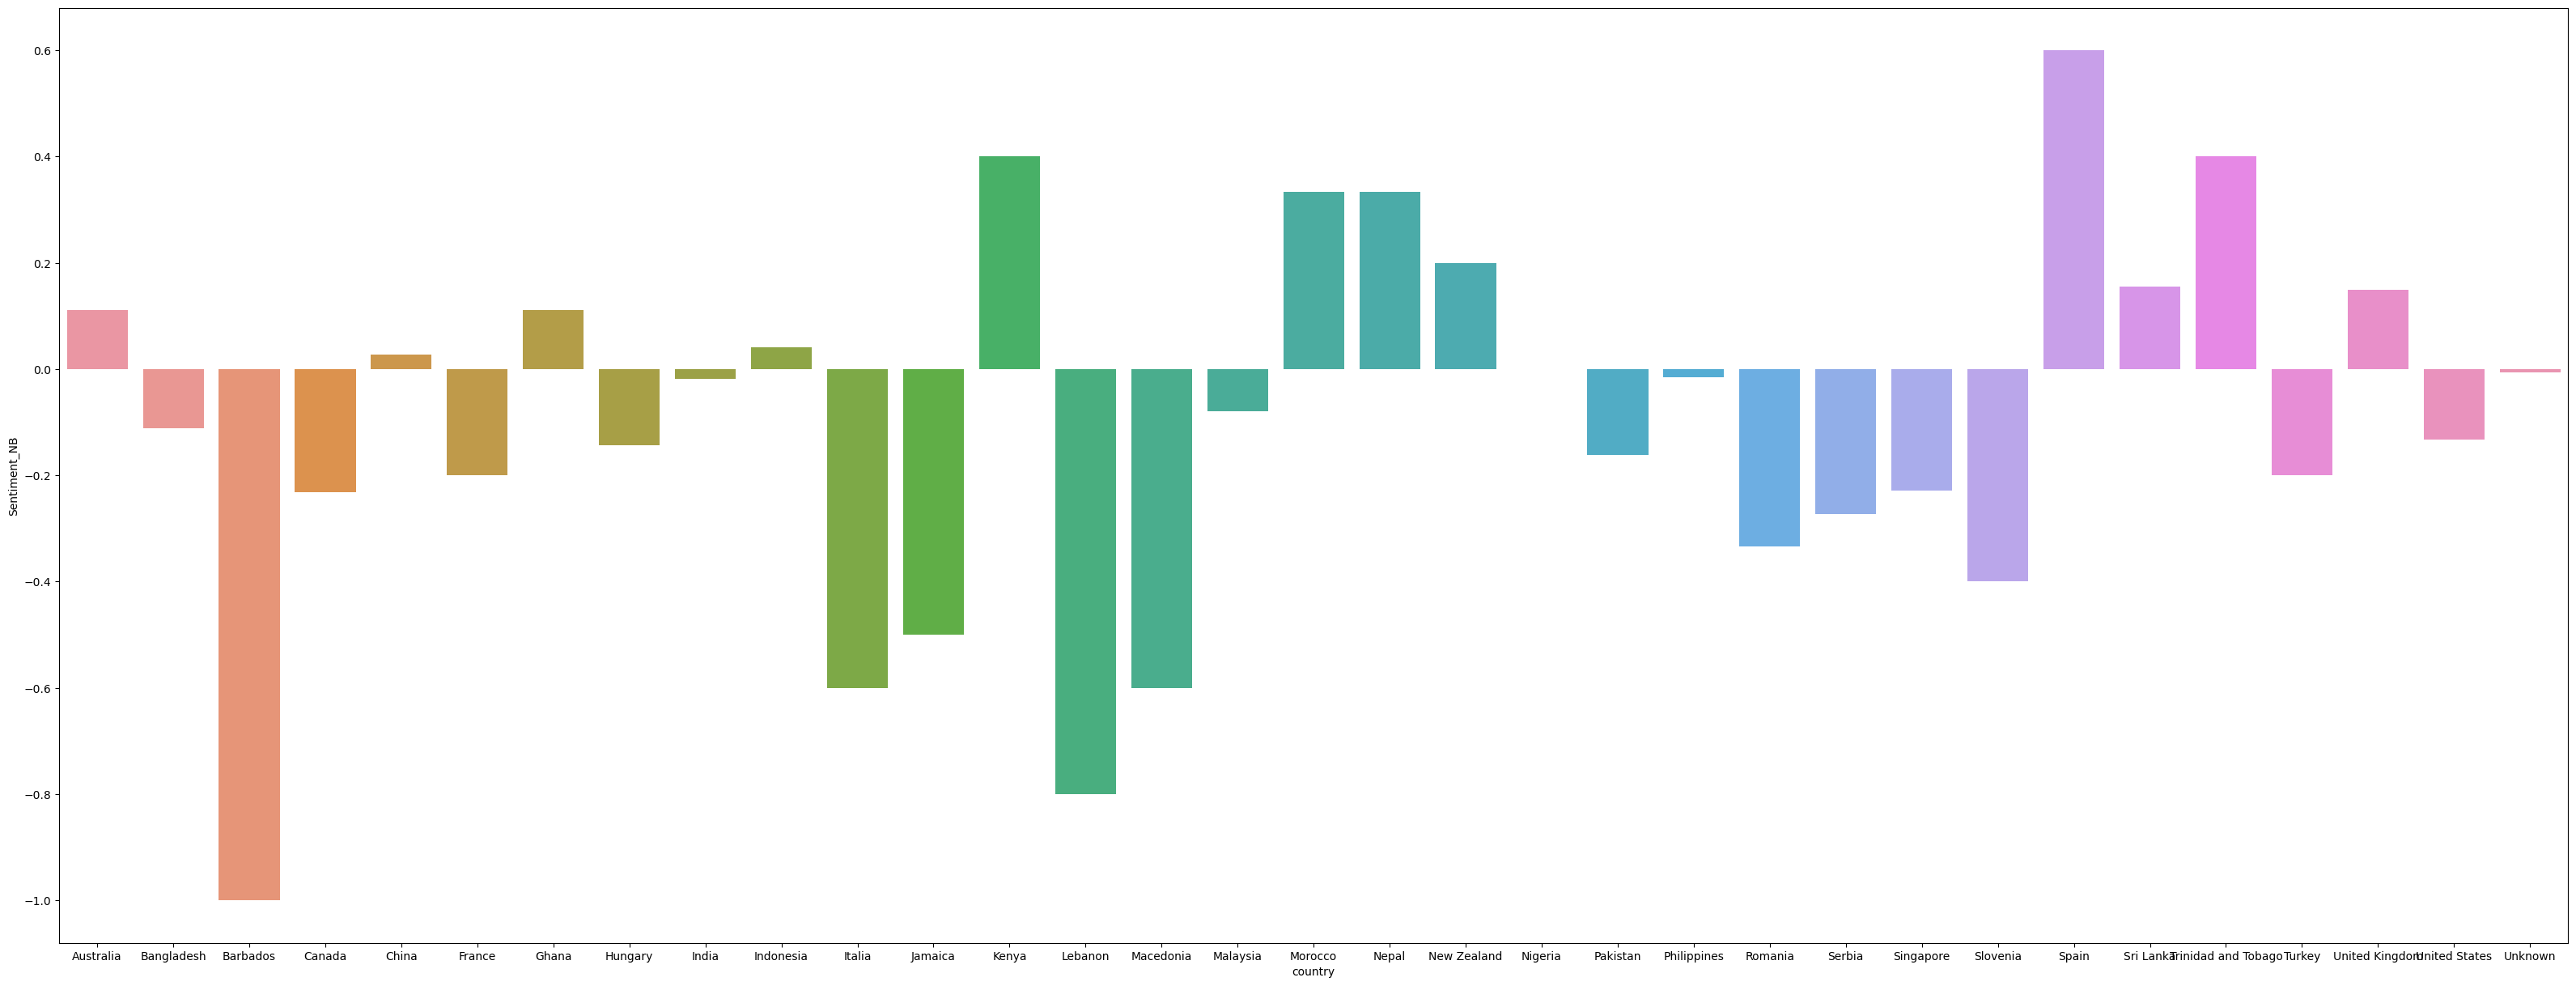

In [40]:
fig, ax = plt.subplots(figsize=(40,15))
sns.barplot(x='country', y='Sentiment_NB', data=df_sent,ax=ax)
plt.show()

# SVM Classifier

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

positive_tw = [(tweet, 1) for tweet in positive_cleaned]
negative_tw = [(tweet, -1) for tweet in negative_cleaned]

data = positive_tw+negative_tw

df_twitter_data = pd.DataFrame(data, columns=['text', 'label'])

df_twitter_data.head()

texts = df_twitter_data.text
texts = [" ".join(text) for text in texts]
labels = df_twitter_data.label.to_list()

In [42]:
#I need to clean texts. Remove #Hashtags and @usernames
clean_texts=[]
for text in texts:
    text = re.sub(r'@\w+', '', text)
    text= re.sub(r'#\w+', '', text)
    clean_texts.append(text)

texts=clean_texts

In [43]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(texts)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
clf = SVC(kernel='rbf')
clf.fit(x_train, y_train)

SVC()

In [45]:
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report: ")
print(classification_report(y_test,y_pred))

Accuracy: 0.7645
Classification Report: 
              precision    recall  f1-score   support

          -1       0.74      0.81      0.77       988
           1       0.79      0.72      0.76      1012

    accuracy                           0.76      2000
   macro avg       0.77      0.77      0.76      2000
weighted avg       0.77      0.76      0.76      2000



In [46]:
# Select one sample message to evaluate
sample_message = df.message_lemmatize[100]
test_data= " ".join(sample_message)
print(test_data)
test_data=vectorizer.transform([test_data]).toarray()
# Print prediction of sentiment
print(clf.predict(test_data))

m going to be late leh .
[-1]


In [47]:
sentiments = []

# Iterate through the column and predict each response's sentiment, append sentiment to new list
for message in df['message_lemmatize']:
    test_data= " ".join(message)
    test_data=vectorizer.transform([test_data]).toarray()
    sentiments.append(clf.predict(test_data))

# add the list back to our DataFrame
df['Sentiment_SVM'] = sentiments

df['Sentiment_SVM'].value_counts()

[-1]    25386
[1]     23209
Name: Sentiment_SVM, dtype: int64

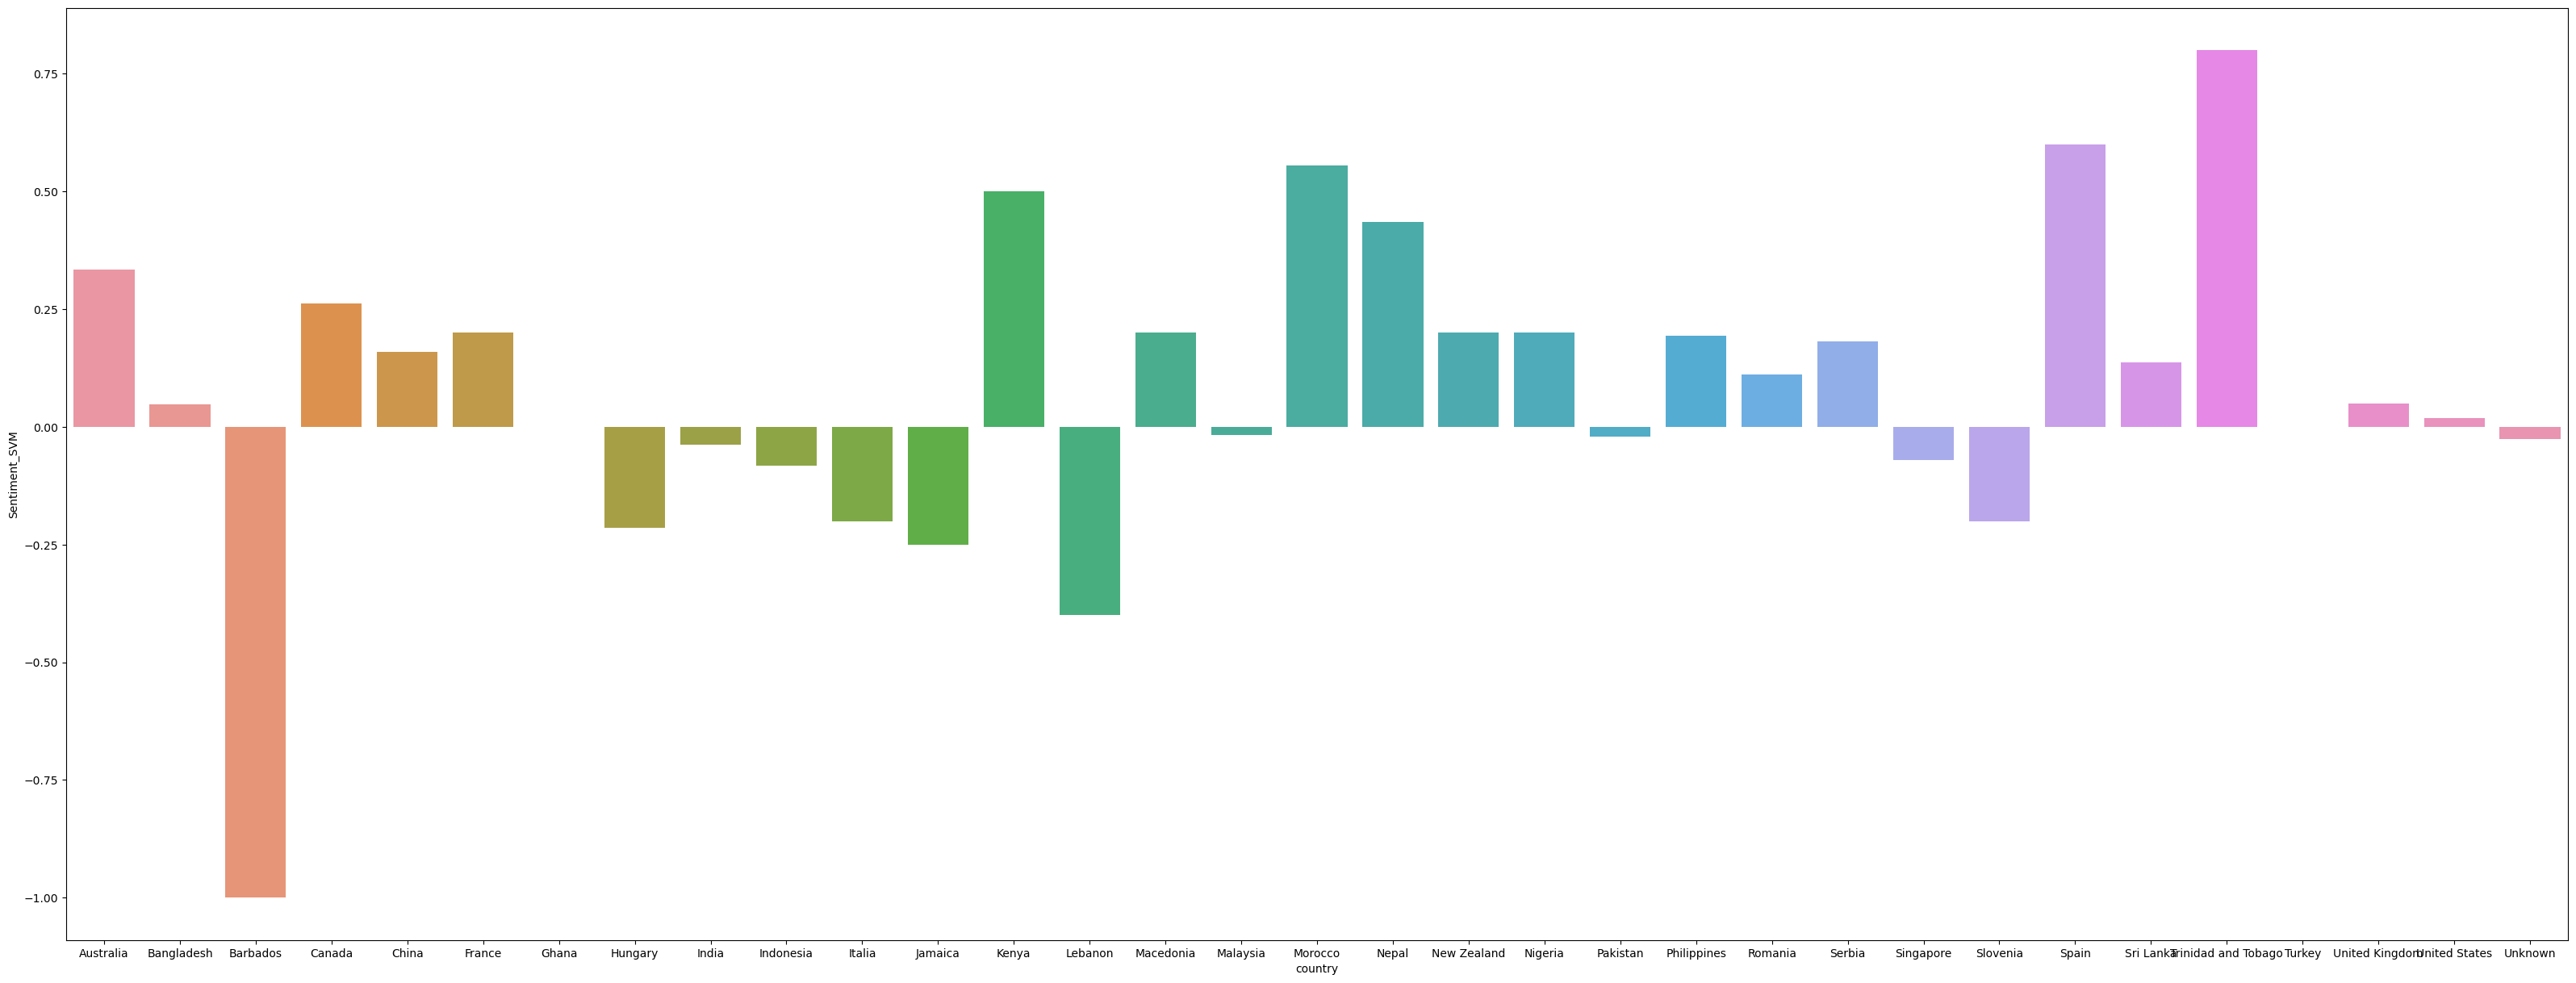

In [48]:
df.Sentiment_SVM=df.Sentiment_SVM.apply(lambda x: int(x))
df_sent = df.groupby(['country']).Sentiment_SVM.mean().reset_index()
fig, ax = plt.subplots(figsize=(40,15))
sns.barplot(x='country', y='Sentiment_SVM', data=df_sent,ax=ax)
plt.show()

# CNN

In [49]:
#Import libraries
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout,Activation, Embedding, LSTM
import wandb


In [50]:
#Lets set up the texts and labels

positive_tw = [(tweet, 1) for tweet in positive_cleaned]
negative_tw = [(tweet, -1) for tweet in negative_cleaned]

data = positive_tw+negative_tw

df_twitter_data = pd.DataFrame(data, columns=['text', 'label'])

texts = df_twitter_data.text
labels = df_twitter_data.label

texts=[' '.join(word) for word in texts]

labels=labels.to_list()

#Now I need to better clean the tweet data. Lets remove all @username and all #Hashtags
clean_texts=[]
for t in texts:
    t = re.sub(r'@\w+', '', t)
    t= re.sub(r'#\w+', '', t)
    clean_texts.append(t)

texts=clean_texts

In [51]:
vocab_size=1000
maxlen=1000
batch_size=32
embedding_dims=10
filters=16
kernal_size=3
hidden_dims=250
epochs=50

In [52]:
tokenizer= Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
texts=tokenizer.texts_to_matrix(texts)

texts=pad_sequences(texts,maxlen=maxlen)

In [53]:
model=Sequential()
model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
model.add(Dropout(0.5))
model.add(Conv1D(filters,kernal_size,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,kernal_size,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(hidden_dims,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
import tensorflow as tf


In [54]:
texts=np.array(texts)
labels=np.array(labels)
model.fit(texts,labels,epochs=epochs,batch_size=batch_size,validation_split=0.2)

Epoch 1/50
250/250 [==============================] - 7s 25ms/step - loss: 0.5629 - accuracy: 0.0044 - val_loss: -0.4299 - val_accuracy: 0.0000e+00
Epoch 2/50
250/250 [==============================] - 6s 24ms/step - loss: -8.5827 - accuracy: 0.2153 - val_loss: -285.1900 - val_accuracy: 0.0000e+00
Epoch 3/50
250/250 [==============================] - 6s 25ms/step - loss: -535.8765 - accuracy: 0.2373 - val_loss: -8087.5386 - val_accuracy: 0.0000e+00
Epoch 4/50
250/250 [==============================] - 6s 26ms/step - loss: -6029.5073 - accuracy: 0.2561 - val_loss: -65203.6484 - val_accuracy: 0.0000e+00
Epoch 5/50
250/250 [==============================] - 7s 26ms/step - loss: -31299.5859 - accuracy: 0.2476 - val_loss: -266747.2500 - val_accuracy: 0.0000e+00
Epoch 6/50
250/250 [==============================] - 6s 26ms/step - loss: -106433.7969 - accuracy: 0.2524 - val_loss: -736267.8125 - val_accuracy: 0.0000e+00
Epoch 7/50
250/250 [==============================] - 7s 27ms/step - loss:

In [55]:
# Select one sample message to evaluate
sample_message = df.message_lemmatize[100]
test_data= " ".join(sample_message)
print(test_data)

tokenizer= Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(test_data)
test_data=tokenizer.texts_to_matrix(test_data)

from scipy.stats import mode
# Print prediction of sentiment
probs=model.predict(test_data)
mode_result=mode(probs,keepdims=False)
most_common = mode_result.mode[0]
print(most_common)

m going to be late leh .
1/1 [==============================] - 0s 142ms/step
0.0


In [56]:
sentiments = []
count=1
# Iterate through the column and predict each response's sentiment, append sentiment to new list
for message in df['message_lemmatize']:
    test_data= " ".join(message)
    tokenizer= Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(test_data)
    test_data=tokenizer.texts_to_matrix(test_data)
    try:
        probs=model.predict(test_data,verbose=0)
        mode_result=mode(probs,keepdims=False)
        most_common = mode_result.mode[0]
        if most_common== 1:
            sentiments.append(1)
        else: 
            sentiments.append(-1)
        print(count)
        count+=1
    except Exception as e:
        print(f"error: {e}")


# add the list back to our DataFrame
df['Sentiment_CNN'] = sentiments

df['Sentiment_CNN'].value_counts()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [ ]:
df.Sentiment_CNN=df.Sentiment_CNN.apply(lambda x: int(x))
df_sent = df.groupby(['country']).Sentiment_CNN.mean().reset_index()
fig, ax = plt.subplots(figsize=(40,15))
sns.barplot(x='country', y='Sentiment_SVM', data=df_sent,ax=ax)
plt.show()

In [ ]:
df.to_csv('outputs.csv',index=False)

# LTSM

In [28]:
#Import libraries
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout,Activation, Embedding, LSTM, Bidirectional
import wandb

In [29]:
#Lets set up the texts and labels

positive_tw = [(tweet, 1) for tweet in positive_cleaned]
negative_tw = [(tweet, -1) for tweet in negative_cleaned]

data = positive_tw+negative_tw

df_twitter_data = pd.DataFrame(data, columns=['text', 'label'])

texts = df_twitter_data.text
labels = df_twitter_data.label

texts=[' '.join(word) for word in texts]

labels=labels.to_list()

#Now I need to better clean the tweet data. Lets remove all @username and all #Hashtags
clean_texts=[]
for t in texts:
    t = re.sub(r'@\w+', '', t)
    t= re.sub(r'#\w+', '', t)
    clean_texts.append(t)

texts=clean_texts

In [30]:
vocab_size=1000
maxlen=1000
batch_size=32
embedding_dims=10
filters=16
kernal_size=3
hidden_dims=250
epochs=50

In [31]:
tokenizer= Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
texts=tokenizer.texts_to_matrix(texts)

texts=pad_sequences(texts,maxlen=maxlen)

In [32]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [34]:
texts=np.array(texts)
labels=np.array(labels)
model.fit(texts,labels,epochs=epochs,batch_size=batch_size,validation_split=0.2)

Epoch 1/50
 11/250 [>.............................] - ETA: 2:27 - loss: 0.5702 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# Select one sample message to evaluate
sample_message = df.message_lemmatize[100]
test_data= " ".join(sample_message)
print(test_data)

tokenizer= Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(test_data)
test_data=tokenizer.texts_to_matrix(test_data)

from scipy.stats import mode
# Print prediction of sentiment
probs=model.predict(test_data)
mode_result=mode(probs,keepdims=False)
most_common = mode_result.mode[0]
print(most_common)

# Hybrid CNN-LTSM Fed with Word Embeddings

This model is in the working stages

In [ ]:
# from gensim.models import Word2Vec
# import numpy as np

# # Step 1: Tokenize the sentences into a list of words
# sentences = ["This is a positive sentence", "This is a negative sentence"]
# tokenized_sentences = [sentence.split() for sentence in sentences]

# # Step 2: Train the word2vec model
# model = Word2Vec(tokenized_sentences, size=embedding_size, window=5, min_count=1)

# # Step 3: Convert the sentences to word2vec embeddings
# X = []
# for sentence in tokenized_sentences:
#   sentence_vector = np.zeros((max_sequence_length, embedding_size))
#   for i, word in enumerate(sentence):
#     if i >= max_sequence_length:
#       break
#     if word in model:
#       sentence_vector[i] = model[word]
#   X.append(sentence_vector)

# # Step 4: Store the resulting sentence vectors
# X = np.array(X)


NameError: name 'embedding_size' is not defined

In [ ]:
# from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
# from keras.models import Model

# max_sequence_length = 100 # maximum length of a sentence
# embedding_size = 300 # word2vec embedding size

# # input layer
# input_layer = Input(shape=(max_sequence_length, embedding_size))

# # CNN component
# cnn = Conv1D(filters=100, kernel_size=3, activation='relu')(input_layer)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)

# # LSTM component
# lstm = LSTM(units=100)(input_layer)

# # concatenate CNN and LSTM outputs
# concat = concatenate([cnn, lstm])

# # fully connected layer
# output = Dense(units=1, activation='sigmoid')(concat)

# # build the model
# model = Model(inputs=input_layer, outputs=output)

# # compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit the model
# model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
